### Import libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import os
import re
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import time
from sklearn.tree import DecisionTreeClassifier

### Data cleaning

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

[nltk_data] Downloading package punkt to C:\Users\Wei
[nltk_data]     Ling\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Wei
[nltk_data]     Ling\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Wei
[nltk_data]     Ling\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Wei Ling\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
# Load data
books_df = pd.read_csv('evaluation_preprocessed_data.csv')


In [4]:
# Check that sentimt is of integer
books_df.dtypes

comment_text     object
manual_label    float64
dtype: object

In [5]:
comment_df = books_df[['comment_text', 'manual_label']]

In [6]:
# drop 2 and 3
comment_df = comment_df[comment_df.manual_label != 2]
comment_df = comment_df[comment_df.manual_label != 3]
comment_df['manual_label'].unique()

array([1., 0.])

In [7]:
def data_cleaning(x):
    x = str(x)
    pattern = '[^a-zA-Z0-9\ ]'
    x = re.sub(pattern,'',x)
    x = x.lower()
    x = x.strip()
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    x = re.sub(r'(.)\1+', r'\1\1', x)
    # Remove - & '
    x = re.sub(r'(-|\')', ' ', x)
    return x

In [8]:
def remove_links_funny_words(x):
    x = re.sub('(https?://[\S]+)', ' URL ', str(x))
    x = x.replace("xmass", "christmas")
    x = x.replace("...", " ")
    x = x.replace("'ll", "will")
    x = x.replace("tewwible", "terrible")
    x = x.replace("frekking", "freaking")
    return x

In [9]:
comment_df = comment_df[comment_df['comment_text'] != '']
comment_df['comment_text'] = comment_df['comment_text'].apply(remove_links_funny_words).apply(data_cleaning)
comment_df.head()

,comment_text,manual_label
0,like dracula need read dracula tape b dracula ...,1.0
1,dracula thread 2022 no one mentioned fantastic...,1.0
2,dracula first published 26th may last thursday...,0.0
3,love dracula im not remotely interested vampir...,1.0
4,vampire general foolish not sure dracula moder...,0.0


In [10]:
# deal with empty values
comment_df['comment_text'] = comment_df['comment_text'].fillna('').apply(str)
comment_df.head()

,comment_text,manual_label
0,like dracula need read dracula tape b dracula ...,1.0
1,dracula thread 2022 no one mentioned fantastic...,1.0
2,dracula first published 26th may last thursday...,0.0
3,love dracula im not remotely interested vampir...,1.0
4,vampire general foolish not sure dracula moder...,0.0


In [11]:
# Stemming
def word_pre(x):
    stemmer = PorterStemmer()
    x = word_tokenize(x)
    store = ''

    for i in x:
        store += stemmer.stem(i) + ' '

    return store

# Stopwords
stop = stopwords.words('english')
additional_stopwords = ["'s","...","'ve","``","''","'m",'--',"'ll","'d"]
stop = set(stop + additional_stopwords)
def remove_stop(x):
    x = word_tokenize(x)
    store = ''

    for i in x:
        if i not in stop:
            store += i + ' '

    return store

def lemmatize(text):
  store = ''
  tokens = word_tokenize(text)
  lemma_function = WordNetLemmatizer()
  for token, tag in pos_tag(tokens):
    store += lemma_function.lemmatize(token, tag_map[tag[0]]) + ' '
  return str(store)

In [12]:
comment_df['comment_cleaned'] = comment_df['comment_text'].apply(remove_stop)

### Split data

In [13]:
x_train, x_test, y_train, y_test = train_test_split(comment_df[['comment_cleaned']],
                                                    comment_df['manual_label'],
                                                    test_size=0.2,
                                                    random_state=0)

In [14]:
vectorizer = CountVectorizer(ngram_range=(1,2))
comment_matrix = vectorizer.fit_transform(x_train['comment_cleaned'])

### SVM

In [15]:
%%time

SVM = svm.SVC(C=1, kernel='poly', gamma=0.1, degree=1).fit(comment_matrix, y_train)

CPU times: total: 125 ms
Wall time: 183 ms


In [16]:
%%time

test_vector = vectorizer.transform(x_test['comment_cleaned'])
result = SVM.predict(test_vector)
confuse = metrics.confusion_matrix(y_test, result)
confuse

CPU times: total: 31.2 ms
Wall time: 44 ms


array([[ 12,  17],
       [  8, 119]], dtype=int64)

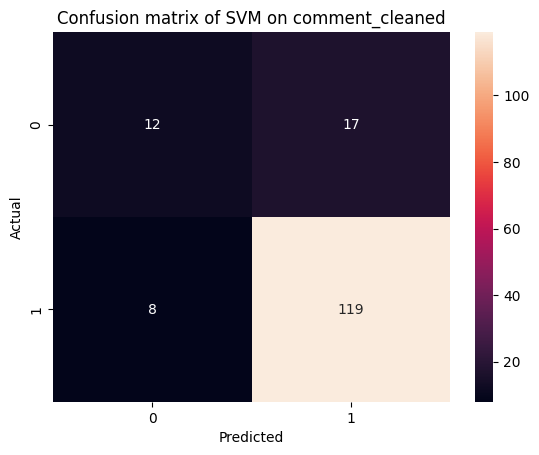

In [17]:
fig = plt.figure()
sns.heatmap(confuse, annot = True, fmt='d')
plt.title("Confusion matrix of SVM on comment_cleaned")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [18]:
svm_F1_score = metrics.f1_score(y_test, result)
svm_average_precision = metrics.average_precision_score(y_test, result)
svm_precision_score= metrics.precision_score(y_test, result)
svm_recall_score = metrics.recall_score(y_test, result)
svm_accuracy = metrics.accuracy_score(y_test, result)

print('F1 score: {0:0.3f}'.format(svm_F1_score))
print('Precision score: {0:0.3f}'.format(svm_precision_score))
print('Recall score: {0:0.3f}'.format(svm_recall_score))
print('Average precision-recall score: {0:0.3f}'.format(svm_average_precision))
print('Accuracy score: {0:0.3f}'.format(svm_accuracy))

F1 score: 0.905
Precision score: 0.875
Recall score: 0.937
Average precision-recall score: 0.871
Accuracy score: 0.840


### Decision Tree

In [19]:
%%time

decision_tree=DecisionTreeClassifier(criterion='gini',splitter='best',max_features='sqrt')
comment_classifier = decision_tree.fit(comment_matrix, y_train)

CPU times: total: 0 ns
Wall time: 17.7 ms


In [20]:
%%time

test_vector = vectorizer.transform(x_test['comment_cleaned'])
result = comment_classifier.predict(test_vector)
confuse = metrics.confusion_matrix(y_test, result)

CPU times: total: 0 ns
Wall time: 12.9 ms


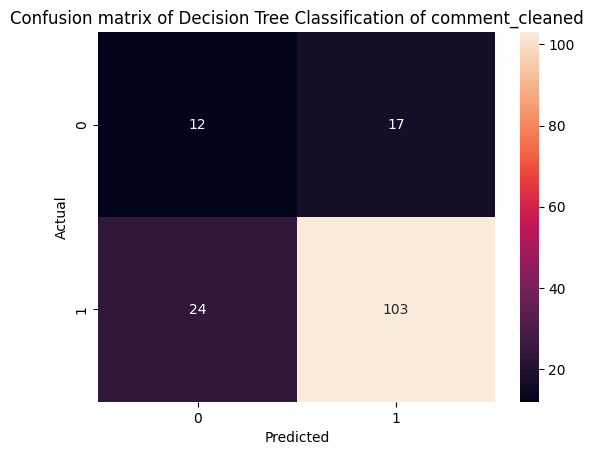

In [21]:
fig = plt.figure()
sns.heatmap(confuse, annot = True, fmt='d')
plt.title("Confusion matrix of Decision Tree Classification of comment_cleaned")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [22]:
dt_F1_score = metrics.f1_score(y_test, result)
dt_average_precision = metrics.average_precision_score(y_test, result)
dt_precision_score= metrics.precision_score(y_test, result)
dt_recall_score = metrics.recall_score(y_test, result)
dt_accuracy = metrics.accuracy_score(y_test, result)

print('F1 score: {0:0.3f}'.format(dt_F1_score))
print('Precision score: {0:0.3f}'.format(dt_precision_score))
print('Recall score: {0:0.3f}'.format(dt_recall_score))
print('Average precision-recall score: {0:0.3f}'.format(dt_average_precision))
print('Accuracy score: {0:0.3f}'.format(dt_accuracy))

F1 score: 0.834
Precision score: 0.858
Recall score: 0.811
Average precision-recall score: 0.850
Accuracy score: 0.737
